# Facial Emotion Recognition using AffectNet dataset with PyTorch

### Notebook 02

This notebook is to carry out the building of models for Facial Emotion recognition (FER) using the `AffectNet` dataset. Experiments to build the best model would be done here.


In [55]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.optim as optim
import torchinfo
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchinfo import summary
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from pathlib import Path
import os
import sys
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random
import numpy as np
import pandas as pd
from collections import Counter





In [5]:
# Get the absolute path to the project root (one level up from the notebook's directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the project root to the Python path
sys.path.append(project_root)

In [6]:
# Import the custom modules
from scripts.data_etl import CustomDataset, DataETL
from utils.common import get_mean_std

<u>Work Plan</u>

1. Load the dataset using ETL
2. Build a baseline model and evaluate
3. Convert training and evaluation loop into a function
4. Experiment with different models - custom and transfer learning
5. Deploy the best model as a flask app for webcam enabled  real time recognition of emotions.

### 1. Load the dataset

In [7]:
proj_dir = Path('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch')

In [8]:
# create path variable for data directory
data_dir = Path(proj_dir / 'data_new')
data_dir

PosixPath('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch/data_new')

In [9]:
data_etl = DataETL(data_dir, 42, number_of_images=None, balanced_data=None)

In [10]:
dataset = CustomDataset(data_dir, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

loader = DataLoader(dataset, batch_size=32, shuffle=True)

[2025-10-21 01:15:09,941: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:15:10,093: INFO: data_etl: Custom data extraction done.]


In [11]:
image, label = next(iter(loader))

In [12]:
image[2].shape

torch.Size([3, 224, 224])

In [13]:
# Load the dataset
data_etl = DataETL(data_dir, 42, 20000, False)

In [14]:
dataset = data_etl.extract_data(transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

[2025-10-21 01:15:23,652: INFO: data_etl: Extracting data......]
[2025-10-21 01:15:23,653: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:15:23,711: INFO: data_etl: Custom data extraction done.]
[2025-10-21 01:15:23,712: INFO: data_etl: Data extraction done......]


In [17]:

train_data, val_data, test_data = data_etl.transform_load(aug_class=['sad', 'disgust', 'contempt', 'fear', 'anger', 'neutral'])


[2025-10-21 01:16:22,471: INFO: data_etl: Transformation started......]
[2025-10-21 01:16:22,472: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:16:22,751: INFO: data_etl: Custom data extraction done.]
[2025-10-21 01:16:22,753: INFO: common: Mean & std calculations......]


[2025-10-21 01:17:33,526: INFO: data_etl: Extracting data......]
[2025-10-21 01:17:33,528: INFO: data_etl: Initializing custom data extraction...]
[2025-10-21 01:17:33,631: INFO: data_etl: Custom data extraction done.]
[2025-10-21 01:17:33,632: INFO: data_etl: Data extraction done......]
[2025-10-21 01:17:33,632: INFO: data_etl: Splitting data started.......]
[2025-10-21 01:17:33,640: INFO: data_etl: Splitting data completed.......]
[2025-10-21 01:17:33,640: INFO: data_etl: Applying data augmentation to training data......]


Augmenting classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.46s/it]


[2025-10-21 01:21:24,656: INFO: data_etl: Train data count: 19545]
[2025-10-21 01:21:24,681: INFO: data_etl: Validation data count: 2000]
[2025-10-21 01:21:24,682: INFO: data_etl: Test data count: 2000]
[2025-10-21 01:21:24,684: INFO: data_etl: Transformation completed]


In [28]:
type(train_data)

torch.utils.data.dataset.TensorDataset

In [31]:
batch_size = 32

In [32]:
# Create the dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=2)

In [33]:
sample_images, sample_labels = next(iter(train_dataloader))

In [34]:
# Check the shape of a sample random image
sample_images[0].shape

torch.Size([3, 224, 224])

# Check class balance

In [35]:
sample_features, sample_label = train_data[0]

In [36]:
sample_label

tensor(5)

In [38]:
idx_to_class = {0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}


In [39]:
idx_to_class

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [40]:
class_counts = Counter([idx_to_class[label.item()] for batch in tqdm(train_dataloader) for label in batch[1]])
print("Class distribution:", class_counts)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 611/611 [00:05<00:00, 102.59it/s]

Class distribution: Counter({'fear': 2469, 'neutral': 2469, 'surprise': 2469, 'anger': 2469, 'contempt': 2469, 'disgust': 2469, 'sad': 2469, 'happy': 2262})


In [41]:
class_counts


Counter({'fear': 2469,
         'neutral': 2469,
         'surprise': 2469,
         'anger': 2469,
         'contempt': 2469,
         'disgust': 2469,
         'sad': 2469,
         'happy': 2262})

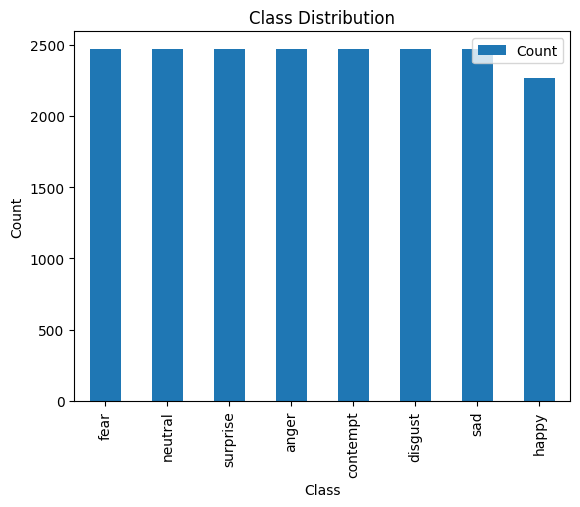

In [42]:
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [62]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using mps device.


In [63]:
model = torch.nn.Sequential()

In [64]:
# Convolutional layer 1 (sees 3x224x224 image tensor)
conv1 = nn.Conv2d(in_channels=3,
                 out_channels=16,
                 kernel_size=3,
                 padding=1)
model.append(conv1)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [65]:
max_pool1 = nn.MaxPool2d(2)
model.append(torch.nn.ReLU())
model.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [66]:
# Convolutional layer 2 (sees 16x112x112 tensor)
conv2 = nn.Conv2d(in_channels=16,
                 out_channels=32,
                 kernel_size=3,
                 padding=1)
max_pool2 = nn.MaxPool2d(2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [67]:
# Convolutional layer 3 (sees 32x56x56 tensor)
conv3 = nn.Conv2d(in_channels=32,
                 out_channels=64,
                 kernel_size=3,
                 padding=1)
max_pool3 = nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [68]:
model.append(torch.nn.Flatten())
model.append(nn.Dropout(0.5))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
)

In [69]:
# Linear layer (64 * 28 * 28 -> 500)
linear1 = nn.Linear(in_features=50176,out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
)


In [70]:
# Linear layer (500 -> 5)
output_layer = nn.Linear(in_features=500,
                        out_features=8)
model.append(output_layer)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)


In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [76]:
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [73]:
height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [74]:
# **AI Lab: Deep Learning for Computer Vision**
# **WorldQuant University**
#
#

# **Usage Guidelines**
#
# This file is licensed under Creative Commons Attribution-NonCommercial-
# NoDerivatives 4.0 International.
#
# You **can** :
#
#   * ✓ Download this file
#   * ✓ Post this file in public repositories
#
# You **must always** :
#
#   * ✓ Give credit to WorldQuant University for the creation of this file
#   * ✓ Provide a link to the license
#
# You **cannot** :
#
#   * ✗ Create derivatives or adaptations of this file
#   * ✗ Use this file for commercial purposes
#
# Failure to follow these guidelines is a violation of your terms of service and
# could lead to your expulsion from WorldQuant University and the revocation
# your certificate.
#
#

from collections import Counter

import pandas as pd
import torch
from tqdm.notebook import tqdm


def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset, "counting classes"))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})


def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)


def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs


def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy


def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    use_train_accuracy=True,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Train one epoch
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        if use_train_accuracy:
            train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        else:
            train_loss = training_loss
            train_accuracy = 0
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"    Training loss: {train_loss:.2f}")
        if use_train_accuracy:
            print(f"    Training accuracy: {train_accuracy:.2f}")
        print(f"    Validation loss: {validation_loss:.2f}")
        print(f"    Validation accuracy: {validation_accuracy:.2f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


# This file © 2024 by WorldQuant University is licensed under CC BY-NC-ND 4.0.


In [77]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model,
    optimizer,
    loss_fn,
    train_dataloader,
    val_dataloader,
    epochs=20,
    device=device,
    use_train_accuracy=True,
)

Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.47
    Training accuracy: 0.45
    Validation loss: 1.52
    Validation accuracy: 0.42


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.23
    Training accuracy: 0.58
    Validation loss: 1.34
    Validation accuracy: 0.50


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.93
    Training accuracy: 0.69
    Validation loss: 1.24
    Validation accuracy: 0.54


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.74
    Training accuracy: 0.79
    Validation loss: 1.22
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.54
    Training accuracy: 0.88
    Validation loss: 1.24
    Validation accuracy: 0.54


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.34
    Training accuracy: 0.93
    Validation loss: 1.26
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.26
    Training accuracy: 0.96
    Validation loss: 1.29
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.18
    Training accuracy: 0.98
    Validation loss: 1.31
    Validation accuracy: 0.56


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.15
    Training accuracy: 0.99
    Validation loss: 1.38
    Validation accuracy: 0.53


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.10
    Training accuracy: 0.99
    Validation loss: 1.44
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 11
    Training loss: 0.07
    Training accuracy: 1.00
    Validation loss: 1.45
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 12
    Training loss: 0.07
    Training accuracy: 0.99
    Validation loss: 1.47
    Validation accuracy: 0.54


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 13
    Training loss: 0.04
    Training accuracy: 1.00
    Validation loss: 1.65
    Validation accuracy: 0.54


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 14
    Training loss: 0.05
    Training accuracy: 1.00
    Validation loss: 1.52
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 15
    Training loss: 0.03
    Training accuracy: 1.00
    Validation loss: 1.64
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 16
    Training loss: 0.03
    Training accuracy: 1.00
    Validation loss: 1.61
    Validation accuracy: 0.55


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 17
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.68
    Validation accuracy: 0.56


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 18
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.73
    Validation accuracy: 0.54


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 19
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.78
    Validation accuracy: 0.53


Training:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/611 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 20
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.69
    Validation accuracy: 0.55


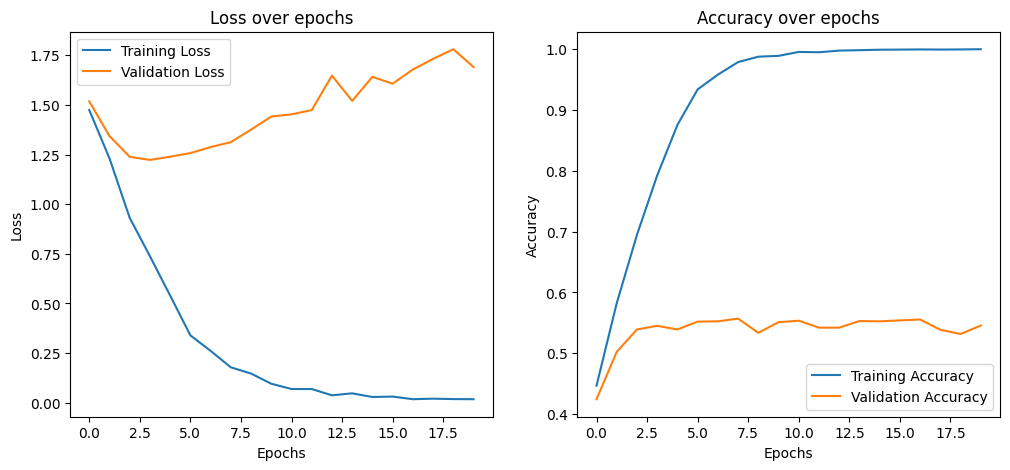

In [78]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()